In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Cargar la data
df = pd.read_csv("caso6_prestamos_personales.csv")


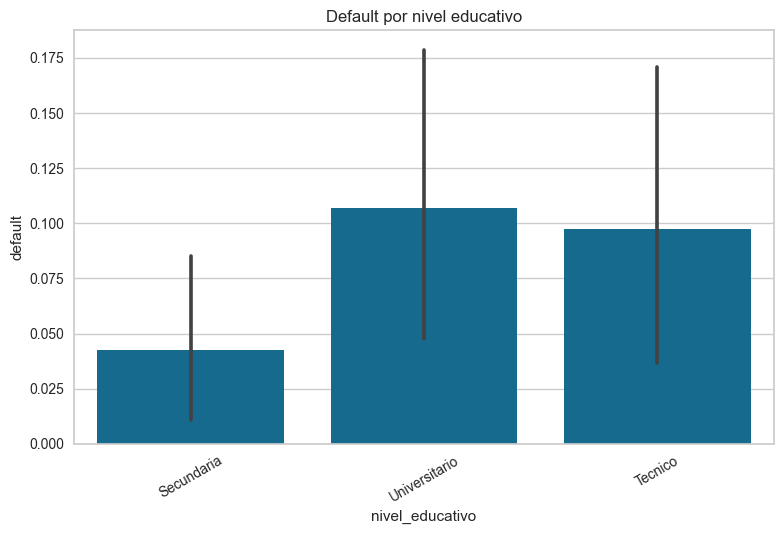

In [3]:
# 2. Análisis exploratorio y posibles sesgos por nivel educativo
sns.barplot(data=df, x='nivel_educativo', y='default')
plt.title("Default por nivel educativo")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [4]:
# 3. Feature engineering no trivial
df['riesgo_cuota'] = df['cuota_vs_ingreso'] * df['ingreso_mensual'] / df['tiempo_laboral_meses']
df['estabilidad_laboral'] = pd.cut(df['tiempo_laboral_meses'], bins=[0, 12, 36, 120, 240],
                                   labels=['Nuevo', 'Intermedio', 'Estable', 'Veterano'])

In [5]:
# 4. Configuración PyCaret con enfoque explicativo y ético
clf = setup(data=df,
            target='default',
            session_id=2025,
            categorical_features=['hist_crediticia', 'nivel_educativo', 'estabilidad_laboral'],
            ignore_features=['cuota_vs_ingreso'],  # ya se incluye en otra variable
            transformation=True,
            polynomial_features=True,
            bin_numeric_features=['edad', 'ingreso_mensual'],
            remove_multicollinearity=True,
            multicollinearity_threshold=0.85
            )

,Description,Value
0,Session id,2025
1,Target,default
2,Target type,Binary
3,Original data shape,"(260, 9)"
4,Transformed data shape,"(260, 67)"
5,Transformed train set shape,"(182, 67)"
6,Transformed test set shape,"(78, 67)"
7,Ignore features,1
8,Numeric features,4
9,Categorical features,3


In [6]:
# 5. Comparación por Recall (prioriza detectar malos clientes)
best_model = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6550,0.5811,0.3500,0.0871,0.1368,0.0143,0.0181,0.0460
lda,Linear Discriminant Analysis,0.8906,0.6403,0.3000,0.2700,0.2786,0.2357,0.2381,0.0450
svm,SVM - Linear Kernel,0.7553,0.4219,0.2000,0.0167,0.0305,0.0013,0.0081,0.0390
dt,Decision Tree Classifier,0.8243,0.5149,0.1500,0.0810,0.1022,0.0246,0.0248,0.0370
ada,Ada Boost Classifier,0.8848,0.5881,0.0500,0.0500,0.0500,0.0132,0.0104,0.0540
gbc,Gradient Boosting Classifier,0.8795,0.6224,0.0500,0.0167,0.0250,-0.0131,-0.0122,0.0670
et,Extra Trees Classifier,0.8904,0.6267,0.0500,0.0250,0.0333,0.0024,0.0038,0.0560
lr,Logistic Regression,0.8959,0.6476,0.0000,0.0000,0.0000,-0.0214,-0.0225,0.5510
knn,K Neighbors Classifier,0.9067,0.4646,0.0000,0.0000,0.0000,-0.0139,-0.0145,0.2880
ridge,Ridge Classifier,0.9126,0.5335,0.0000,0.0000,0.0000,-0.0075,-0.0081,0.0390


In [8]:
# 6. Ajustar y afinar con F1 score
final = tune_model(best_model, optimize='F1')
evaluate_model(final)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5263,0.4412,0.5000,0.1111,0.1818,0.0116,0.0181
1,0.5789,0.3529,0.0000,0.0000,0.0000,-0.1875,-0.2330
2,0.6667,0.8824,1.0000,0.1429,0.2500,0.1692,0.3040
3,0.8333,1.0000,1.0000,0.2500,0.4000,0.3415,0.4537
4,0.5556,0.2353,0.0000,0.0000,0.0000,-0.1077,-0.1935
5,0.5556,0.4118,0.0000,0.0000,0.0000,-0.1077,-0.1935
6,0.6667,0.7059,0.0000,0.0000,0.0000,-0.1020,-0.1504
7,0.7222,0.7188,0.5000,0.2000,0.2857,0.1509,0.1754
8,0.7778,0.4062,0.0000,0.0000,0.0000,-0.1250,-0.1250


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [10]:
# 7. Simular un cliente en riesgo y mejorar su perfil
cliente_riesgoso = pd.DataFrame({
    'edad': [24],
    'ingreso_mensual': [1500],
    'hist_crediticia': ['Regular'],
    'nivel_educativo': ['Tecnico'],
    'tiempo_laboral_meses': [6],
    'riesgo_cuota': [600 * 1500 / 6],  # cuota vs ingreso estimado
    'estabilidad_laboral': ['Nuevo']
})
cliente_mejorado = cliente_riesgoso.copy()
cliente_mejorado['ingreso_mensual'] = 2500
cliente_mejorado['tiempo_laboral_meses'] = 24
cliente_mejorado['riesgo_cuota'] = 600 * 2500 / 24
cliente_mejorado['estabilidad_laboral'] = 'Intermedio'

print("🔍 Riesgo actual:")
print(predict_model(final, data=cliente_riesgoso))

print("Riesgo si mejora estabilidad:")
print(predict_model(final, data=cliente_mejorado))

🔍 Riesgo actual:


   edad  ingreso_mensual hist_crediticia nivel_educativo  \
0    24             1500         Regular         Tecnico   

   tiempo_laboral_meses  riesgo_cuota estabilidad_laboral  prediction_label  \
0                     6      150000.0               Nuevo                 0   

   prediction_score  
0               1.0  
Riesgo si mejora estabilidad:


   edad  ingreso_mensual hist_crediticia nivel_educativo  \
0    24             2500         Regular         Tecnico   

   tiempo_laboral_meses  riesgo_cuota estabilidad_laboral  prediction_label  \
0                    24       62500.0          Intermedio                 0   

   prediction_score  
0               1.0  


In [11]:
# 8. Exportar modelo para conectarlo con API externa
save_model(final, 'modelo_scoring_credito_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['edad', 'ingreso_mensual',
                                              'tiempo_laboral_meses',
                                              'riesgo_cuota'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(e...
                                     include=['edad', 'ingreso_mensual'],
             